# Comparison of different approches

In [5]:
import glob
import os
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm_notebook as tqdm
import json
import pickle
import skl_groups
from skl_groups.divergences import KNNDivergenceEstimator
from skl_groups.features import Features
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-darkgrid')
import seaborn as sns
import sys
sys.path.append("../../..")
import src.measures
import scipy.stats

In [6]:
folders = [fil for fil in os.listdir('.') if os.path.isdir(fil) and fil[0] == "R"]

In [7]:
def exploration(X_s):
    """
    This function computes the exploration measure, i.e. the number of cells reached in the state space.

    Args:
        + explorer: the explorer of the environment
        + bins: the number of bins per dimension
    """
    
    n_samples, n_dim = X_s.shape
    
    hist, _ = np.histogramdd(X_s, bins=10, range=np.array([[-1]*n_dim, [1]* n_dim]).T)
    
    return float(hist[hist>0].size) / float(hist.size)

def divergence_estimation(X_s, X_l, k=10):

    div = KNNDivergenceEstimator(div_funcs=['kl'], Ks=[k], n_jobs=4, clamp=True, do_sym = 1)
    X_s = X_s.astype(np.float32)
    X_l = X_l.astype(np.float32)
    f_s = Features(X_s, n_pts=[X_s.shape[0]])
    f_l = Features(X_l, n_pts=[X_l.shape[0]])
    div.fit(X=f_s)
    kls = div.transform(X=f_l).squeeze()

    return kls

def discretized_kl_div(X_s, n_bins=30):
    
    n_samples, n_dim = X_s.shape
    
    histp , _ = np.histogramdd(X_s, bins=n_bins, range=np.array([[-1]*n_dim, [1]* n_dim]).T)
    
    histp = histp.ravel() / histp.sum()
    
    histq = np.ones(histp.shape)
    
    histq = histq / histq.sum()
    
    return scipy.stats.entropy(histp, histq)


def discretized_entropy(X_s, n_bins=30):
    
    n_samples, n_dim = X_s.shape
    
    histp , _ = np.histogramdd(X_s, bins=n_bins, range=np.array([[-1]*n_dim, [1]* n_dim]).T)
    
    histp = histp.ravel() / histp.sum()
    
    return scipy.stats.entropy(histp)


def sample_in_attainable(nb_points, env):
    
    if env == 'armball':
        i = 0
        X = np.ndarray((nb_points, 2))
        while not i == nb_points:
            sample = np.random.uniform(-1, 1, 2)
            if np.linalg.norm(sample, ord=2) >1.:
                continue
            X[i] = sample
            i += 1
        return X
        
    if env == 'armarrow':
        i = 0
        X = np.ndarray((nb_points, 3))
        while not i == nb_points:
            sample = np.random.uniform(-1, 1, 3)
            if np.linalg.norm(sample[0:2], ord=2) > 1.:
                continue
            X[i] = sample
            i += 1
        return X
    
def kl_exploration(X_s):
    
    if X_s.shape[-1] == 2:
        env = 'armball'
    elif X_s.shape[-1] == 3:
        env = 'armarrow'
        
    X_l = sample_in_attainable(X_s.shape[0], env)
    
    kls = divergence_estimation(X_s, X_l)
    
    return kls[1]
    


In [8]:
dataset = pd.DataFrame()

In [10]:
for fold in tqdm(folders):
    
    try:
          
        with open(os.path.join(fold, "config.json")) as f:
            config = json.load(f)

        with open(os.path.join(fold, "explored_states_history.pkl"), 'rb') as f:
            explored_states = pickle.load(f)
        
        
    except Exception as e:
        print("Folder %s failed with exception %s"%(fold, str(e)))
        continue
    
    
    for i in range(49):
        serie = copy.copy(config)
        serie.update({'epoch': (i+1)*10*10})
        serie.update({'distribution_entropy': discretized_kl_div(explored_states[i*10])})
        serie.update({'entropy': discretized_entropy(explored_states[i*10])})
        
        dataset = dataset.append(serie, ignore_index=True)
        

A Jupyter Widget

/home/apere/anaconda3/envs/py-2.7/lib/python2.7/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in multiply
  return getattr(obj, method)(*args, **kwds)


Folder Rge-Rep Ae Armarrow 2017-12-12 16:12:30.912752 failed with exception [Errno 2] No such file or directory: 'Rge-Rep Ae Armarrow 2017-12-12 16:12:30.912752/explored_states_history.pkl'
Folder Rge-Rep Isomap Armarrow 2018-01-03 09:05:30.801314 failed with exception [Errno 2] No such file or directory: 'Rge-Rep Isomap Armarrow 2018-01-03 09:05:30.801314/explored_states_history.pkl'
Folder Rge-Rep Vae Armarrow 2017-12-14 08:39:46.659604 failed with exception [Errno 2] No such file or directory: 'Rge-Rep Vae Armarrow 2017-12-14 08:39:46.659604/explored_states_history.pkl'
Folder Rge-Rep Ae Armarrow 2018-01-03 09:04:59.583792 failed with exception [Errno 2] No such file or directory: 'Rge-Rep Ae Armarrow 2018-01-03 09:04:59.583792/explored_states_history.pkl'



In [11]:
ds = dataset['name'].str.extract("^(.*)\s(Armball|Armarrow)")
dataset["algorithm"] = ds[0]

/home/apere/anaconda3/envs/py-2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


In [12]:
dataset.to_pickle(path='dataset2.pkl')

In [13]:
dataset = dataset.replace('Rge-Fi', 'Rge-Efr')
dataset = dataset.replace('Rge-Rep Isomap', 'Rge-Iso.')
dataset = dataset.replace('Rge-Rep Ae', 'Rge-Ae')
dataset = dataset.replace('Rge-Rep Pca', 'Rge-Pca')
dataset = dataset.replace('Rge-Rep Rfvae', 'Rge-Rfvae')
dataset = dataset.replace('Rge-Rep Vae', 'Rge-Vae')

## ArmBall Small Dims

/home/apere/anaconda3/envs/py-2.7/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


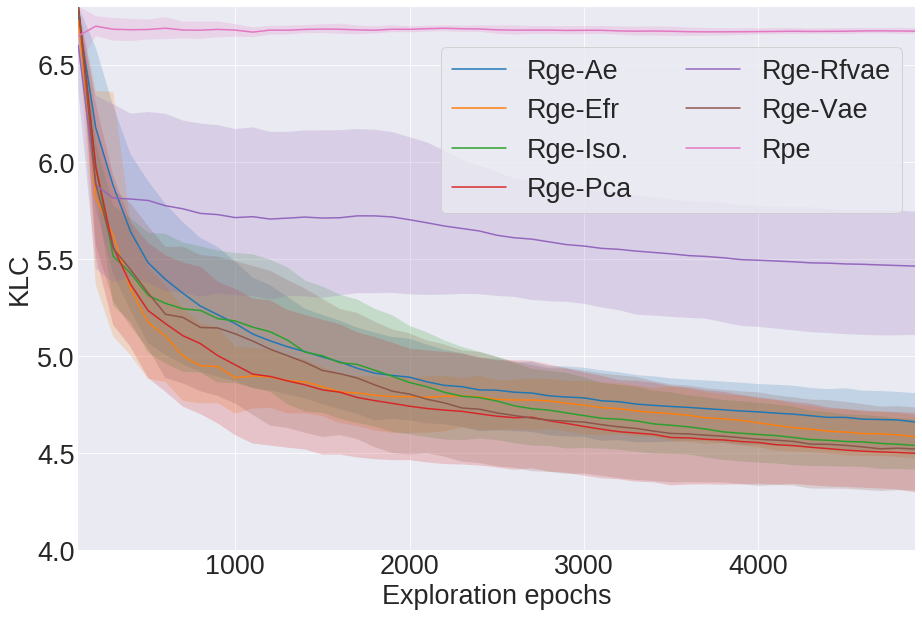

In [14]:
# We retrieve Dataset
fontsize=27
env = "armball"
sampling = "normal"
nlatents = 10
ds = dataset.query('environment==@env and sampling!=@sampling and nlatents!=@nlatents').sort_values(['algorithm'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='distribution_entropy',unit='name', condition='algorithm', ci=90)
plt.ylabel('KLC', fontsize=fontsize)
plt.ylim(4.0, 6.8)
plt.yticks(fontsize=fontsize, )
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
#plt.title("ArmBall - 2 Latents", fontsize=fontsize)
plt.legend(title="", fontsize=fontsize, loc=1, frameon=1, ncol=2, fancybox=True, bbox_to_anchor=(1., .95));
plt.savefig('Figures/armball_discretized_dkl_exploration_2_latents.pdf')

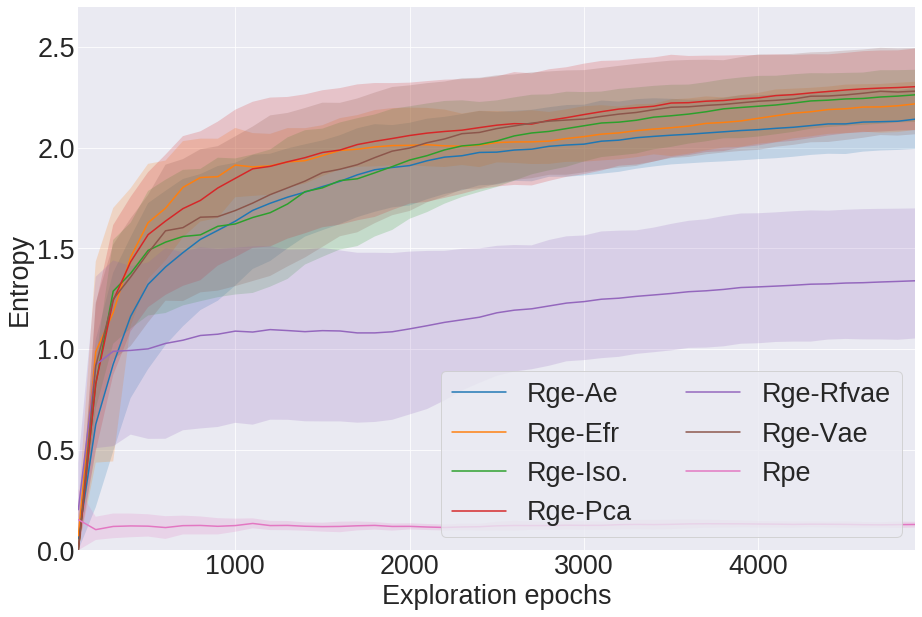

In [22]:
# We retrieve Dataset
fontsize=27
env = "armball"
sampling = "normal"
nlatents = 10
ds = dataset.query('environment==@env and sampling!=@sampling and nlatents!=@nlatents').sort_values(['algorithm'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='entropy',unit='name', condition='algorithm', ci=90)
plt.ylabel('Entropy', fontsize=fontsize)
plt.ylim(0.0, 2.7)
plt.yticks(fontsize=fontsize, )
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
#plt.title("ArmBall - 2 Latents", fontsize=fontsize)
plt.legend(title="", fontsize=fontsize, loc=0, frameon=1, ncol=2, fancybox=True)
plt.savefig('Figures/armball_discretized_entropy_exploration_2_latents.pdf')

## ArmBall Large Dims

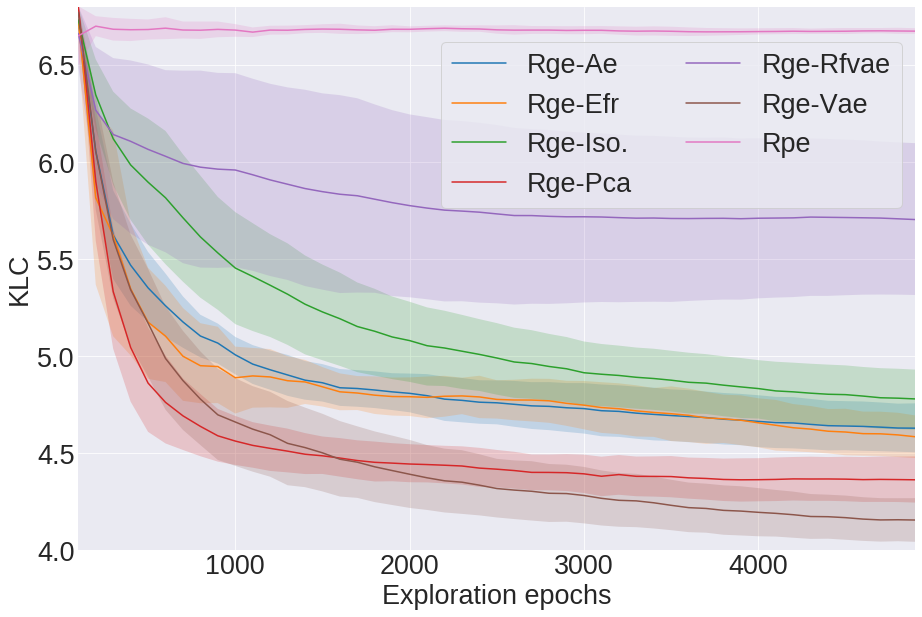

In [114]:
# We retrieve Dataset
env = "armball"
sampling = "normal"
nlatents = 2
ds = dataset.query('environment==@env and sampling!=@sampling and nlatents!=@nlatents').sort_values(['algorithm'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='distribution_entropy',unit='name', condition='algorithm', ci=90)
plt.ylabel('KLC', fontsize=fontsize)
plt.ylim(4.0, 6.8)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
#plt.title("ArmBall - 10 Latents", fontsize=fontsize)
plt.legend(title="", fontsize=fontsize, loc=1, frameon=1, ncol=2, fancybox=True, bbox_to_anchor=(1., .96));
plt.savefig('Figures/armball_discretized_dkl_exploration_10_latents.pdf')

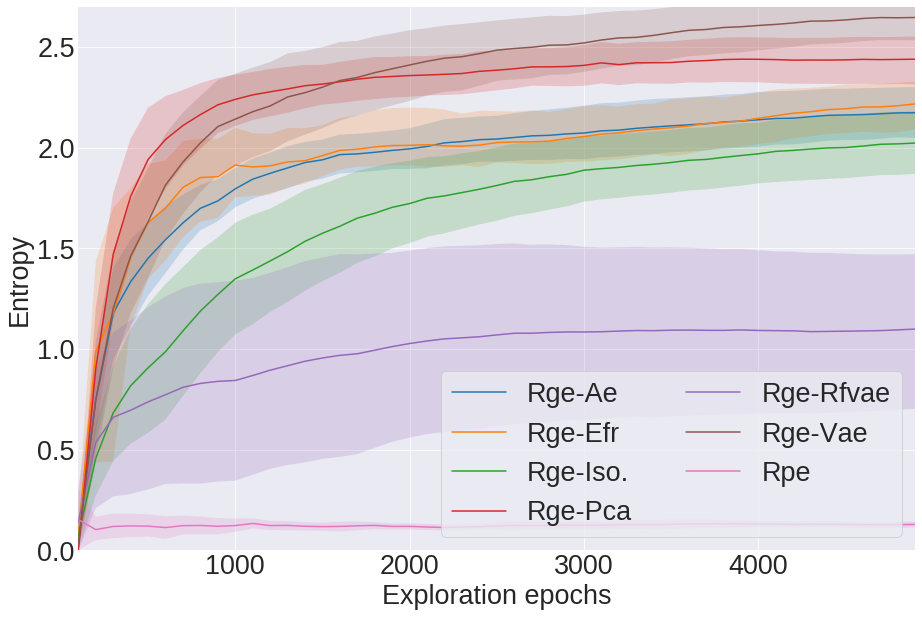

In [28]:
# We retrieve Dataset
env = "armball"
sampling = "normal"
nlatents = 2
ds = dataset.query('environment==@env and sampling!=@sampling and nlatents!=@nlatents').sort_values(['algorithm'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='entropy',unit='name', condition='algorithm', ci=90)
plt.ylabel('Entropy', fontsize=fontsize)
plt.ylim(0, 2.7)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
#plt.title("ArmBall - 10 Latents", fontsize=fontsize)
plt.legend(title="", fontsize=fontsize, loc=0, frameon=1, ncol=2, fancybox=True);
plt.savefig('Figures/armball_discretized_entropy_exploration_10_latents.pdf')

## ArmArrow Small Dims

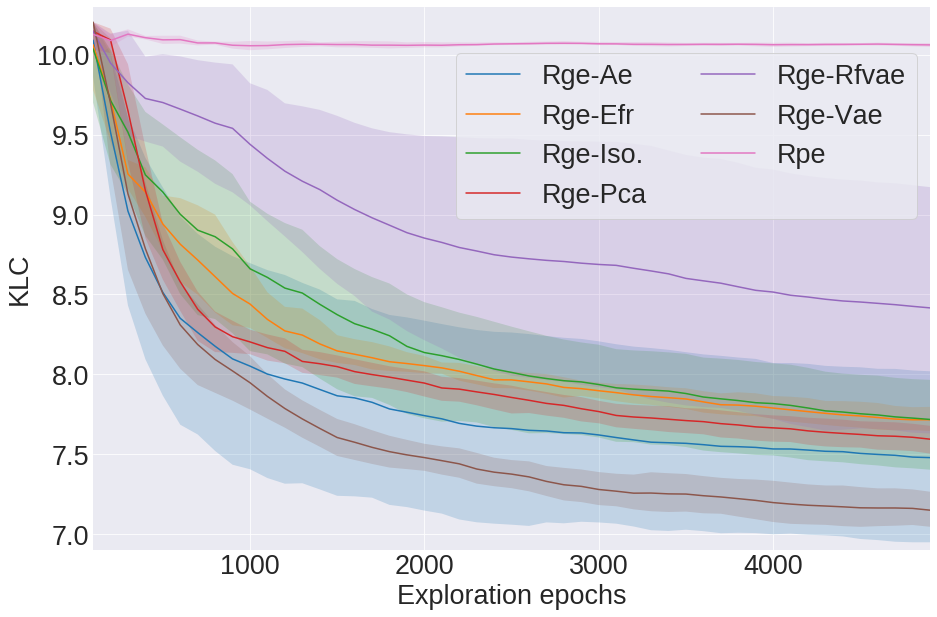

In [115]:
# We retrieve Dataset
env = "armarrow"
sampling = "normal"
nlatents = 10
ds = dataset.query('environment==@env and sampling!=@sampling and nlatents!=10 and nlatents!=4').sort_values(['algorithm'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='distribution_entropy', unit='name', condition='algorithm', ci=90)
plt.ylabel('KLC', fontsize=fontsize)
plt.ylim(6.9, 10.3)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
#plt.title("ArmArrow - 3 Latents", fontsize=fontsize)
plt.legend(title="", fontsize=fontsize, loc=1, frameon=1, ncol=2, fancybox=True, bbox_to_anchor=(1., .94));
plt.savefig('Figures/armarrow_discretized_dkl_exploration_3_latents.pdf')

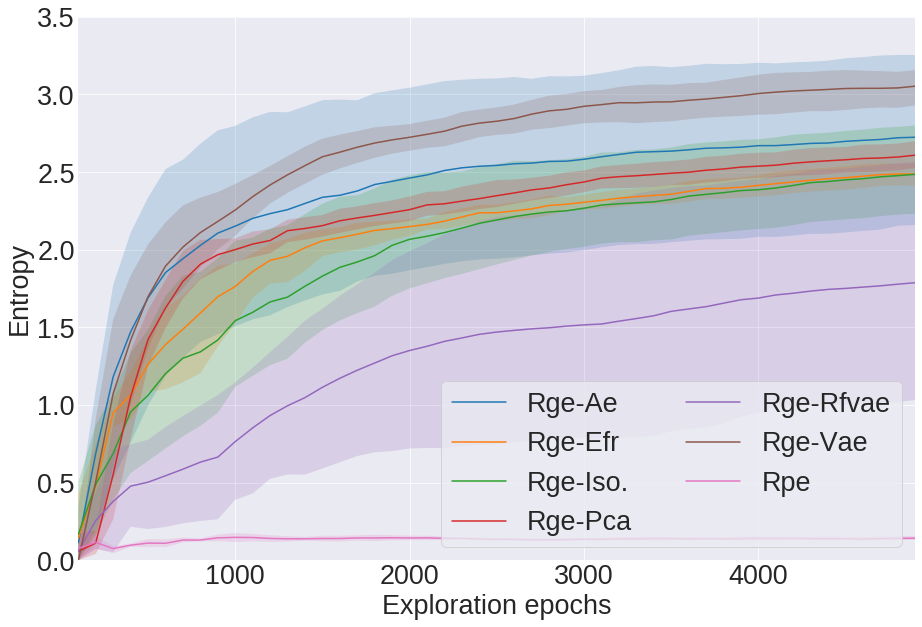

In [29]:
# We retrieve Dataset
env = "armarrow"
sampling = "normal"
nlatents = 10
ds = dataset.query('environment==@env and sampling!=@sampling and nlatents!=10 and nlatents!=4').sort_values(['algorithm'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='entropy', unit='name', condition='algorithm', ci=90)
plt.ylabel('Entropy', fontsize=fontsize)
plt.ylim(0, 3.5)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
#plt.title("ArmArrow - 3 Latents", fontsize=fontsize)
plt.legend(title="", fontsize=fontsize, loc=0, frameon=1, ncol=2, fancybox=True);
plt.savefig('Figures/armarrow_discretized_entropy_exploration_3_latents.pdf')

## ArmArrow Large Dims

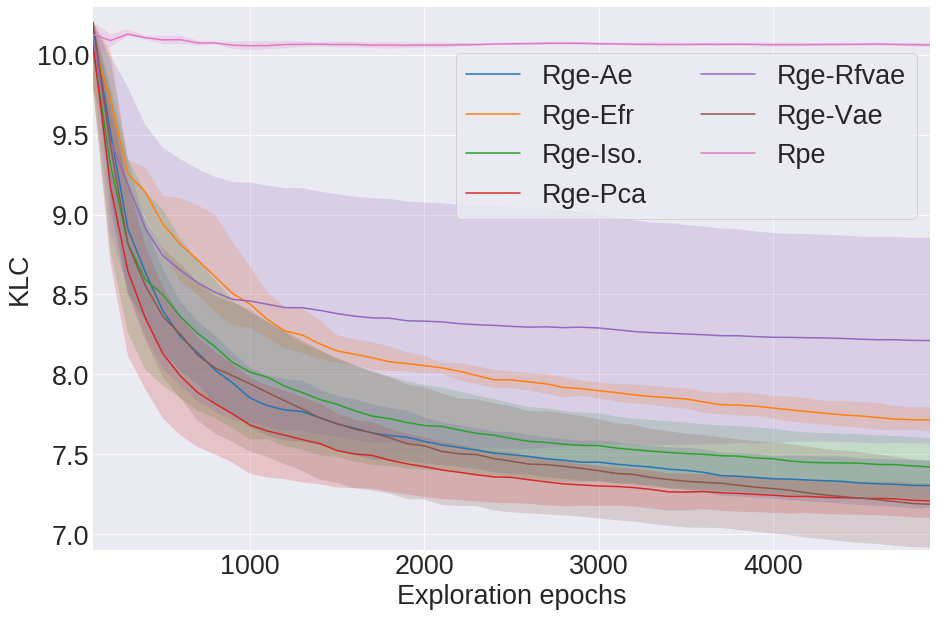

In [30]:
# We retrieve Dataset
env = "armarrow"
sampling = "normal"
nlatents = 4
ds = dataset.query('environment==@env and sampling!=@sampling and nlatents!=4 and nlatents!=3').sort_values(['algorithm'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='distribution_entropy', unit='name', condition='algorithm', ci=90)
plt.ylabel('KLC', fontsize=fontsize)
plt.ylim(6.9, 10.3)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
#plt.title("ArmArrow - 10 Latents", fontsize=fontsize)
plt.legend(title="", fontsize=fontsize, loc=1, frameon=1, ncol=2, fancybox=True, bbox_to_anchor=(1., .94));
plt.savefig('Figures/armarrow_discretized_dkl_exploration_10_latents.pdf')

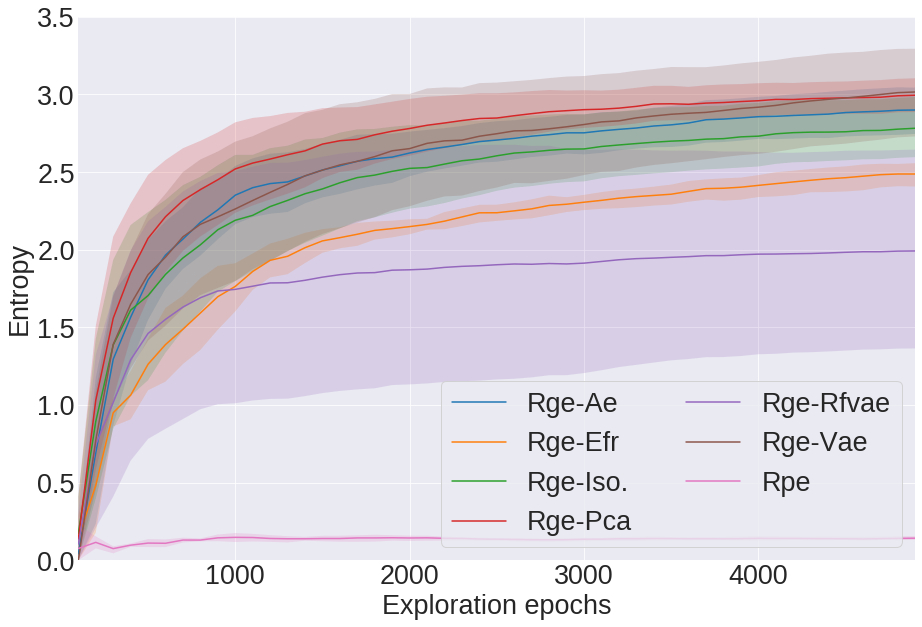

In [32]:
# We retrieve Dataset
env = "armarrow"
sampling = "normal"
nlatents = 4
ds = dataset.query('environment==@env and sampling!=@sampling and nlatents!=4 and nlatents!=3').sort_values(['algorithm'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='entropy', unit='name', condition='algorithm', ci=90)
plt.ylabel('Entropy', fontsize=fontsize)
plt.ylim(0., 3.5)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
#plt.title("ArmArrow - 10 Latents", fontsize=fontsize)
plt.legend(title="", fontsize=fontsize, loc=0, frameon=1, ncol=2, fancybox=True);
plt.savefig('Figures/armarrow_discretized_entropy_exploration_10_latents.pdf')

## Vae norm vs kde

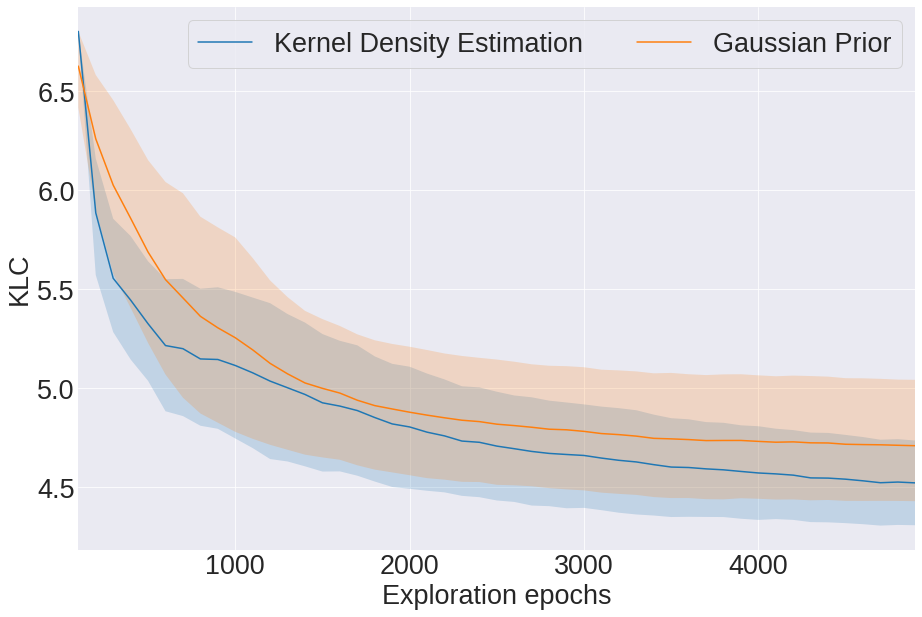

In [34]:
# We retrieve Dataset
env = "armball"
embedding= "vae"
nlatents = 2
ds = dataset.query('environment==@env and embedding==@embedding and nlatents==@nlatents').sort_values(['sampling'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='distribution_entropy', unit='name', condition='sampling', ci=90)
plt.ylabel('KLC', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
plt.legend(title="", );
#plt.suptitle("ArmBall - 2 Latents", fontsize=24)
plt.legend(["Kernel Density Estimation", 'Gaussian Prior'], title="", fontsize=fontsize, loc=1, frameon=1, ncol=2, fancybox=True);
plt.savefig('Figures/armball_discretized_dkl_exploration_sampling_strategy_2_latents.pdf')

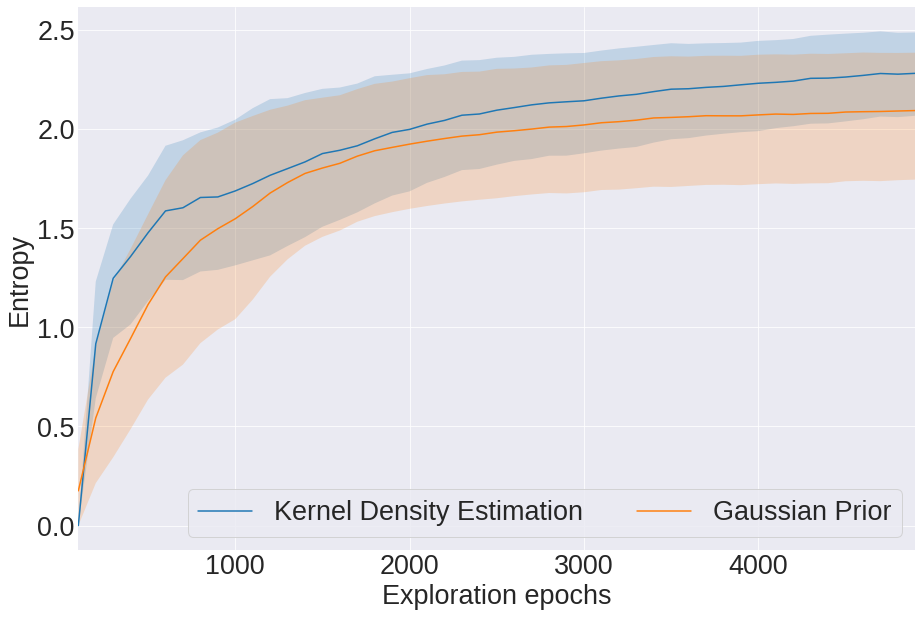

In [39]:
# We retrieve Dataset
env = "armball"
embedding= "vae"
nlatents = 2
ds = dataset.query('environment==@env and embedding==@embedding and nlatents==@nlatents').sort_values(['sampling'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='entropy', unit='name', condition='sampling', ci=90)
plt.ylabel('Entropy', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
plt.legend(title="", );
#plt.suptitle("ArmBall - 2 Latents", fontsize=24)
plt.legend(["Kernel Density Estimation", 'Gaussian Prior'], title="", fontsize=fontsize, loc=4, frameon=1, ncol=2, fancybox=True);
plt.savefig('Figures/armball_discretized_entropy_exploration_sampling_strategy_2_latents.pdf')

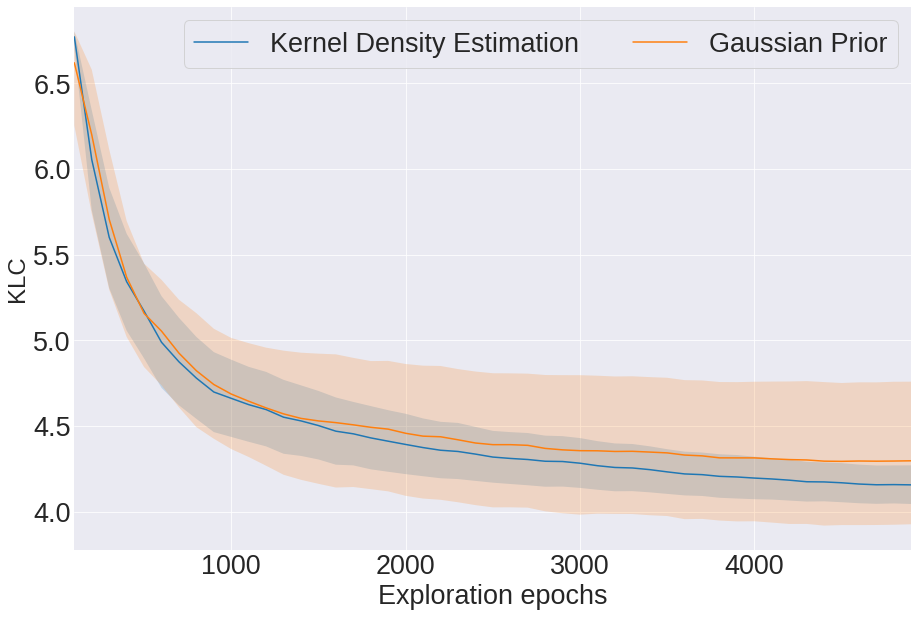

In [122]:
# We retrieve Dataset
env = "armball"
embedding= "vae"
nlatents = 10
ds = dataset.query('environment==@env and embedding==@embedding and nlatents==@nlatents').sort_values(['sampling'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='distribution_entropy', unit='name', condition='sampling', ci=90)
plt.ylabel('KLC', fontsize=24)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
plt.legend(title="", );
#plt.suptitle("ArmBall - 10 Latents", fontsize=24)
plt.legend(["Kernel Density Estimation", 'Gaussian Prior'], title="", fontsize=fontsize, loc=1, frameon=1, ncol=2, fancybox=True);
plt.savefig('Figures/armball_discretized_dkl_exploration_sampling_strategy_10_latents.pdf')

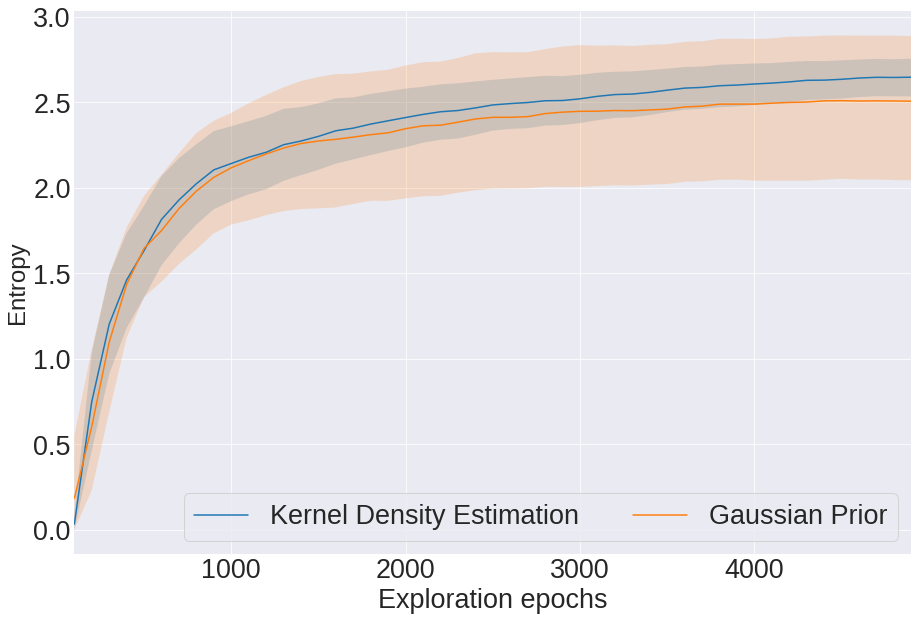

In [40]:
# We retrieve Dataset
env = "armball"
embedding= "vae"
nlatents = 10
ds = dataset.query('environment==@env and embedding==@embedding and nlatents==@nlatents').sort_values(['sampling'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='entropy', unit='name', condition='sampling', ci=90)
plt.ylabel('Entropy', fontsize=24)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
plt.legend(title="", );
#plt.suptitle("ArmBall - 10 Latents", fontsize=24)
plt.legend(["Kernel Density Estimation", 'Gaussian Prior'], title="", fontsize=fontsize, loc=4, frameon=1, ncol=2, fancybox=True);
plt.savefig('Figures/armball_discretized_entropy_exploration_sampling_strategy_10_latents.pdf')

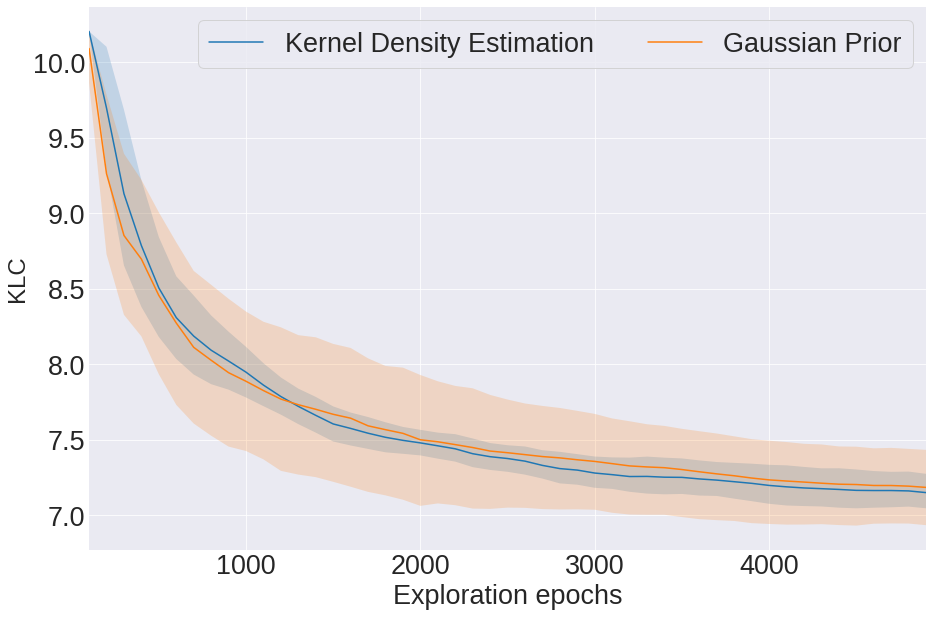

In [123]:
# We retrieve Dataset
env = "armarrow"
embedding= "vae"
nlatents = 3
ds = dataset.query('environment==@env and embedding==@embedding and nlatents==@nlatents').sort_values(['sampling'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='distribution_entropy', unit='name', condition='sampling', ci=90)
plt.ylabel('KLC', fontsize=24)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
plt.legend(title="", );
#plt.suptitle("ArmArrow - 3 Latents", fontsize=24)
plt.legend(["Kernel Density Estimation", 'Gaussian Prior'], title="", fontsize=fontsize, loc=1, frameon=1, ncol=2, fancybox=True);
plt.savefig('Figures/armarrow_discretized_dkl_exploration_sampling_strategy_3_latents.pdf')

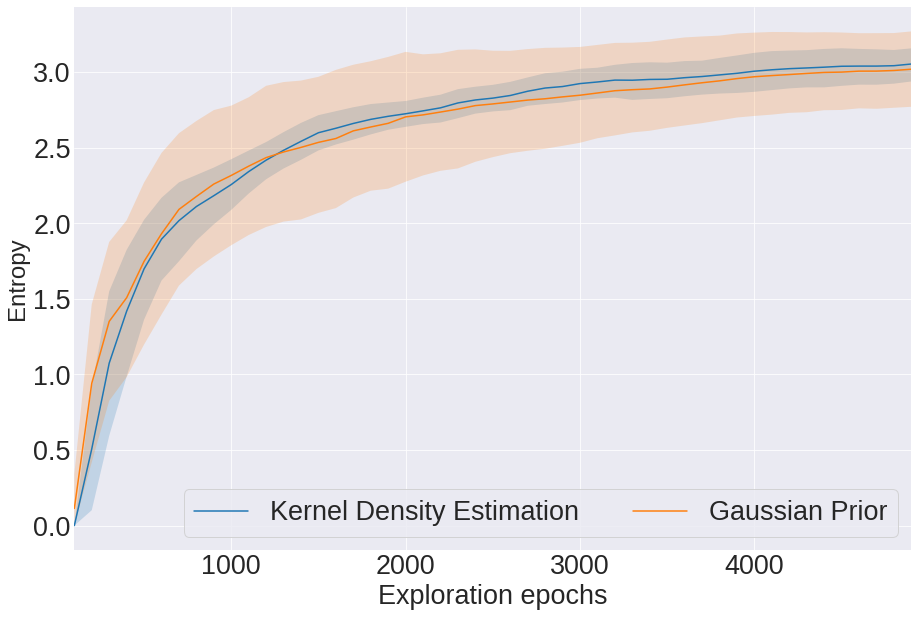

In [41]:
# We retrieve Dataset
env = "armarrow"
embedding= "vae"
nlatents = 3
ds = dataset.query('environment==@env and embedding==@embedding and nlatents==@nlatents').sort_values(['sampling'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='entropy', unit='name', condition='sampling', ci=90)
plt.ylabel('Entropy', fontsize=24)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
plt.legend(title="", );
#plt.suptitle("ArmArrow - 3 Latents", fontsize=24)
plt.legend(["Kernel Density Estimation", 'Gaussian Prior'], title="", fontsize=fontsize, loc=4, frameon=1, ncol=2, fancybox=True);
plt.savefig('Figures/armarrow_discretized_entropy_exploration_sampling_strategy_3_latents.pdf')

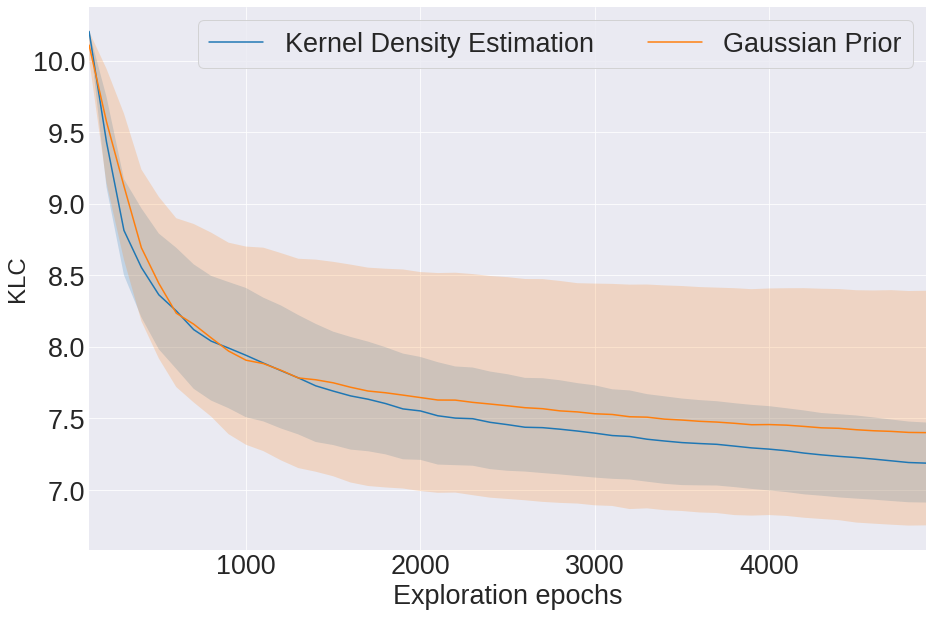

In [124]:
# We retrieve Dataset
env = "armarrow"
embedding= "vae"
nlatents = 10
ds = dataset.query('environment==@env and embedding==@embedding and nlatents==@nlatents').sort_values(['sampling'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='distribution_entropy', unit='name', condition='sampling', ci=90)
plt.ylabel('KLC', fontsize=24)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
plt.legend(title="", );
#plt.suptitle("ArmArrow - 10 Latents", fontsize=24)
plt.legend(["Kernel Density Estimation", 'Gaussian Prior'], title="", fontsize=fontsize, loc=1, frameon=1, ncol=2, fancybox=True);
plt.savefig('Figures/armarrow_discretized_dkl_exploration_sampling_strategy_10_latents.pdf')

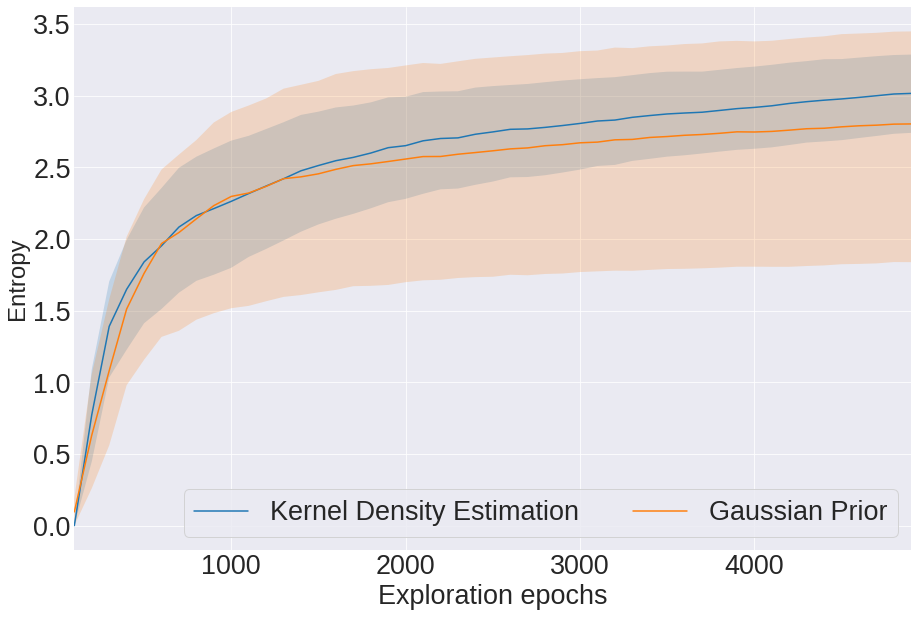

In [42]:
# We retrieve Dataset
env = "armarrow"
embedding= "vae"
nlatents = 10
ds = dataset.query('environment==@env and embedding==@embedding and nlatents==@nlatents').sort_values(['sampling'])
ds = ds.drop_duplicates(subset=["epoch", "name"])
plt.figure(figsize=(15,10))
sns.tsplot(data=ds, time='epoch', value='entropy', unit='name', condition='sampling', ci=90)
plt.ylabel('Entropy', fontsize=24)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel("Exploration epochs", fontsize=fontsize)
plt.legend(title="", );
#plt.suptitle("ArmArrow - 10 Latents", fontsize=24)
plt.legend(["Kernel Density Estimation", 'Gaussian Prior'], title="", fontsize=fontsize, loc=4, frameon=1, ncol=2, fancybox=True);
plt.savefig('Figures/armarrow_discretized_entropy_exploration_sampling_strategy_10_latents.pdf')